In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
import functions as fn
from collections import defaultdict
import os


In [2]:
wd = "/Genomics/kocherlab/bjarnold/Nmel"
# wd = "/Genomics/kocherlab/bjarnold/Avir"
# wd = "/Genomics/kocherlab/bjarnold/Aaur"

bioreps = ['F1', 'F2', 'F3']

macs_peaks_files = fn.get_files(f'{wd}/MACS2', "*_peaks.narrowPeak")
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

genrich_peaks_files = fn.get_files(f'{wd}/genrich_single', "*_peaks.narrowPeak")
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)
genrich_multi_peak_file = fn.get_files(f'{wd}/genrich_multi', "*_peaks.narrowPeak")[0]
genrich_pileup_files = fn.get_files(f'{wd}/genrich_single', "*_pileups.txt")

chr1_test = False
qval_threshold = 1 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 2
genrich_area_threshold = 20
min_interval_size = 200
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping
dist_thresh = 300 # distance b/t peak summits, used for overlapping results across methods or bioreps
print(macs_peaks_files)
print(genrich_peaks_files)
print(genrich_pileup_files)

['/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F3_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/MACS2/Nmel-F1_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F3_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F1_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F1_pileups.txt', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F3_pileups.txt', '/Genomics/kocherlab/bjarnold/Nmel/genrich_single/Nmel-F2_pileups.txt']


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [3]:
pileup_dfs = fn.load_genrich_pileup_files(genrich_pileup_files, chr1_test=chr1_test)

In [4]:
macs_dfs = [] # list of macs dataframes
genrich_dfs = [] # list of genrich dataframes

macs_dfs = fn.load_peak_caller_results(macs_peaks_files, chr1_test)
genrich_dfs = fn.load_peak_caller_results(genrich_peaks_files, chr1_test)
genrich_multi_df = fn.load_peak_caller_results([genrich_multi_peak_file], chr1_test)[0]

# FILTER PEAK FILES BY SIGNIFICANCE, EFFECT SIZE
macs_dfs = fn.filter_by_sig_effect_size(macs_dfs, qval_threshold, macs_folddiff_threshold)
genrich_dfs = fn.filter_by_sig_effect_size(genrich_dfs, qval_threshold, genrich_area_threshold)

print([len(df) for df in macs_dfs])



before filtering: 112283
after filtering: 42201
before filtering: 110197
after filtering: 37431
before filtering: 110250
after filtering: 40206
before filtering: 134246
after filtering: 40119
before filtering: 121542
after filtering: 29869
before filtering: 132921
after filtering: 46182
[42201, 37431, 40206]


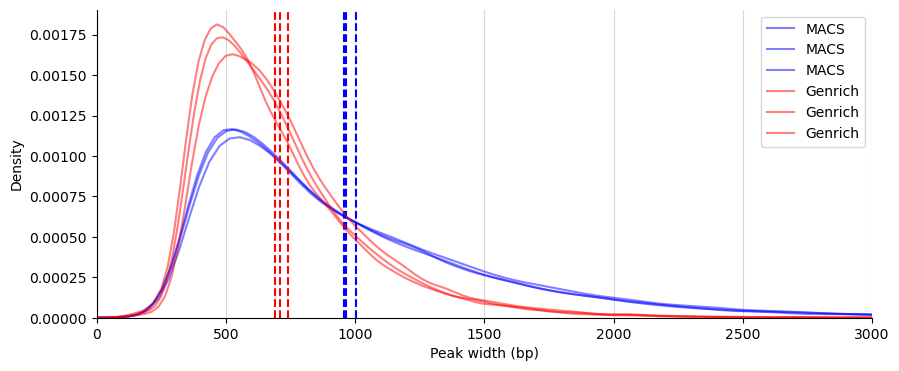

In [5]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="MACS")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in genrich_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="Genrich")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")
axs.set_ylabel("Density")
axs.grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
sns.despine()


# Compare MACS2 and Genrich within biological replicates, where we expect results to be the same

In [6]:
for m in macs_dfs:
    # convert peak/summit coordinate into an interval to overlap with pyranges
    m['peak_coord_1'] = m['peak_coord'] + 1

# gather relevant columns, put in new list of dataframes
macs_summit_dfs = [m[['Chromosome', 'peak_coord', 'peak_coord_1', 'signalValue']] for m in macs_dfs]

# rename columns to match pyranges format
for m in macs_summit_dfs:
    m.columns = ['Chromosome', 'Start', 'End', 'signalValue']

# convert df to pyranges object
macs_summit_prs = [pr.PyRanges(m) for m in macs_summit_dfs]
pileup_prs = [pr.PyRanges(p) for p in pileup_dfs]

# overlap macs peaks with genrich pileups
macs_with_pileup_dfs = []
for p,m in zip(pileup_prs, macs_summit_prs):
    macs_with_pileup_dfs.append( p.join(m, how="right").df )

In [7]:
for m in macs_with_pileup_dfs:
    print(np.corrcoef(m.fold_diff, m.signalValue))

[[1.         0.91934745]
 [0.91934745 1.        ]]
[[1.         0.92928296]
 [0.92928296 1.        ]]
[[1.         0.93793653]
 [0.93793653 1.        ]]


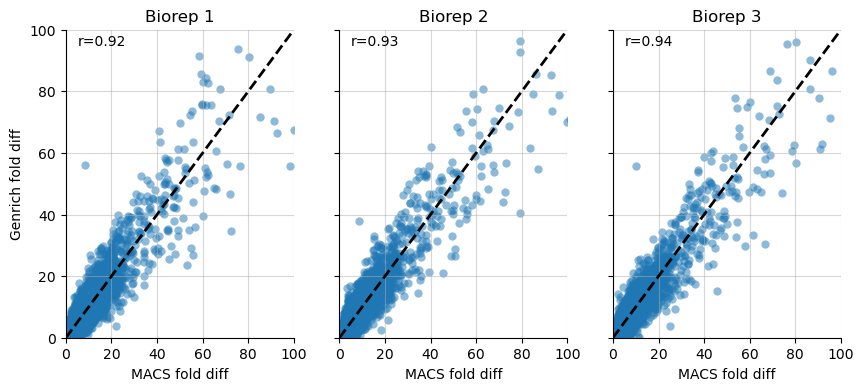

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,m in enumerate(macs_with_pileup_dfs):
    sns.scatterplot(x=m.signalValue, y=m.fold_diff, ax=axs[i], linewidth=0, alpha=0.5)
    axs[i].set_title(f"Biorep {i+1}")
    axs[i].set_xlabel("MACS fold diff")
    axs[i].set_ylabel("Genrich fold diff")    
    axs[i].set_xlim(0,100)
    axs[i].set_ylim(0,100)
    axs[i].plot([0, 100], [0, 100], linewidth=2, color='black', linestyle='--')
    # add grid lines
    axs[i].grid(True, alpha=0.5)
    # add correlation coefficient in plot
    corr = np.corrcoef(m.fold_diff, m.signalValue)[0,1]
    axs[i].text(0.05, 0.95, f"r={corr:.2f}", transform=axs[i].transAxes)

sns.despine()

# COMPARE PEAKS (NOT SUMMITS, WHICH IS THE APEX OF THE INTERVAL CALLED BY METHOD)

In [9]:

# look at concordance of peak calling between methods, witihin bioreps
macs_peaks_overlaps, genrich_peaks_overlaps = fn.get_peak_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)
for i,m in enumerate(macs_peaks_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_peaks_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# fraction of overlap can seem odd if one caller has smaller peaks that are contained within a larger peak from the other caller

[(42201, 0.7564749650482216), (37431, 0.6333253185861986), (40206, 0.8237079042928916)]
[(40119, 0.9780403300181959), (29869, 0.991094445746426), (46182, 0.8798882681564246)]
MACS2: 42201 peaks, 75.65% overlap with Genrich peaks
MACS2: 37431 peaks, 63.33% overlap with Genrich peaks
MACS2: 40206 peaks, 82.37% overlap with Genrich peaks
Genrich: 40119 peaks, 97.80% overlap with MACS2 peaks
Genrich: 29869 peaks, 99.11% overlap with MACS2 peaks
Genrich: 46182 peaks, 87.99% overlap with MACS2 peaks


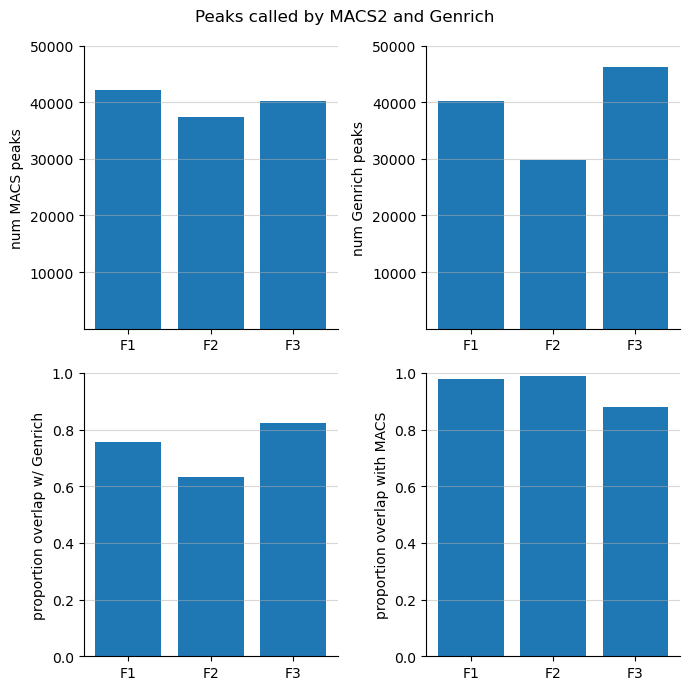

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharex=False, sharey=False)
t = range(len(macs_peaks_overlaps))
axs[0][0].bar(t, [m[0] for m in macs_peaks_overlaps])
axs[0][0].set_ylabel("num MACS peaks")
axs[0][0].set_xticks(t)
axs[0][0].set_yticks([10000, 20000, 30000, 40000, 50000])
axs[0][0].set_xticklabels(bioreps)
axs[0][0].grid(axis='y', alpha=0.5)

axs[0][1].bar(t, [g[0] for g in genrich_peaks_overlaps])
axs[0][1].set_ylabel("num Genrich peaks")
axs[0][1].set_xticks(t)
axs[0][1].set_yticks([10000, 20000, 30000, 40000, 50000])
axs[0][1].set_xticklabels(bioreps)
axs[0][1].grid(axis='y', alpha=0.5)


axs[1][0].bar(t, [m[1] for m in macs_peaks_overlaps])
axs[1][0].set_ylim(0,1)
axs[1][0].set_ylabel("proportion overlap w/ Genrich")
axs[1][0].set_xticks(t)
axs[1][0].set_xticklabels(bioreps)
axs[1][0].grid(axis='y', alpha=0.5)



axs[1][1].bar(t, [g[1] for g in genrich_peaks_overlaps])
axs[1][1].set_ylim(0,1)
axs[1][1].set_ylabel("proportion overlap with MACS")
axs[1][1].set_xticks(t)
axs[1][1].set_xticklabels(bioreps)
axs[1][1].grid(axis='y', alpha=0.5)

fig.suptitle("Peaks called by MACS2 and Genrich")


sns.despine()
plt.tight_layout()

# Compare MACS and Genrich between biological replicates

In [11]:
# look at overlaps within methods between bioreps
macs_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_dfs, bioreps, frac_overlap)
genrich_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(genrich_dfs, bioreps, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)

[(42201, 37431, 14091), (42201, 40206, 14084), (37431, 40206, 13784)]
[(40119, 29869, 11040), (40119, 46182, 13151), (29869, 46182, 11965)]


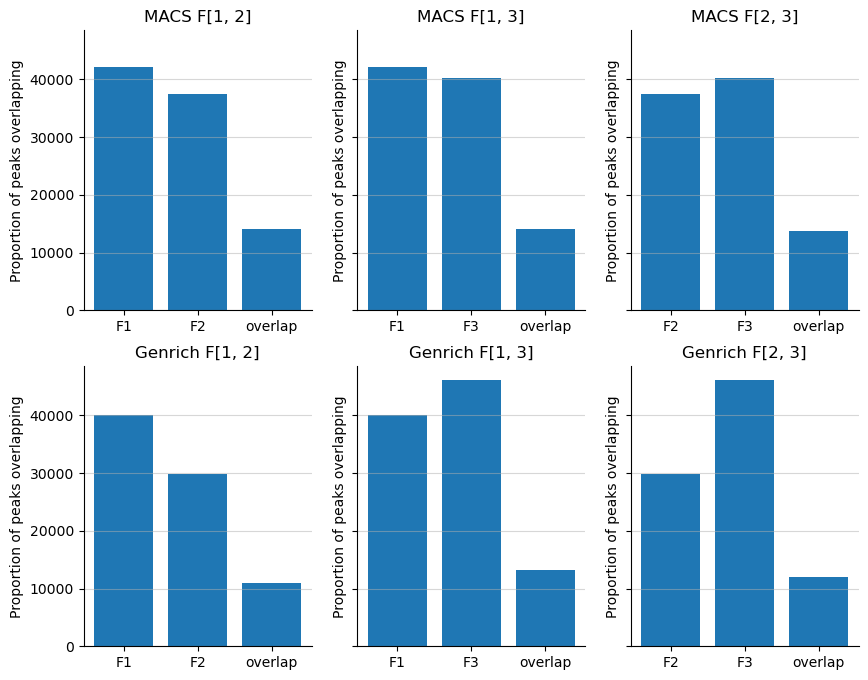

In [12]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_peaks_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[0][i].bar(range(len(comp)), comp)
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_peaks_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[1][i].bar(range(len(comp)), comp)
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

In [56]:
p1 = pr.PyRanges(chromosomes=genrich_dfs[0].Chromosome,
                starts=genrich_dfs[0].Start,
                ends=genrich_dfs[0].End)
p2 = pr.PyRanges(chromosomes=genrich_dfs[1].Chromosome,
                    starts=genrich_dfs[1].Start,
                    ends=genrich_dfs[1].End)
p3 = pr.PyRanges(chromosomes=genrich_dfs[2].Chromosome,
                    starts=genrich_dfs[2].Start,
                    ends=genrich_dfs[2].End)

gr = {"p1":p1, "p2":p2, "p3":p3}

overlaps_per_rep = pr.count_overlaps(gr)
overlaps_per_rep = overlaps_per_rep.df
overlaps_per_rep['combined'] = overlaps_per_rep['p1'].astype(str) + overlaps_per_rep['p2'].astype(str) + overlaps_per_rep['p3'].astype(str)
# it looks like count_overlaps is counting overlaps b/t all instervals
# if all three replicates have an overlapping interval, pattern could look like this:
#       Chromosome	Start	End	    p1	p2	p3
# 7	    NMEL_chr_1	9079	9297	0	0	0
# 8	    NMEL_chr_1	9297	9309	1	0	0
# 9	    NMEL_chr_1	9309	9649	1	1	0
# 10	NMEL_chr_1	9649	10150	1	1	1
# 11	NMEL_chr_1	10150	10843	0	1	1
# 12	NMEL_chr_1	10843	10914	0	0	1
# 13	NMEL_chr_1	10914	16276	0	0	0
# where index 10 is interval in which all 3 peaks are overlapping, but since start/end points of the peaksare different,
# we can see that replicate 1 has the minimum starting point, and replicate 3 has the maximum ending point


def overlaps_per_replicate(dfs):
    p1 = pr.PyRanges(chromosomes=dfs[0].Chromosome,
                starts=dfs[0].Start,
                ends=dfs[0].End)
    p2 = pr.PyRanges(chromosomes=dfs[1].Chromosome,
                        starts=dfs[1].Start,
                        ends=dfs[1].End)
    p3 = pr.PyRanges(chromosomes=dfs[2].Chromosome,
                        starts=dfs[2].Start,
                        ends=dfs[2].End)

    gr = {"p1":p1, "p2":p2, "p3":p3}
    overlaps_per_rep = pr.count_overlaps(gr)
    overlaps_per_rep = overlaps_per_rep.df
    overlaps_per_rep['combined'] = overlaps_per_rep['p1'].astype(str) + overlaps_per_rep['p2'].astype(str) + overlaps_per_rep['p3'].astype(str)
    return overlaps_per_rep

genrich_overlaps_per_rep = overlaps_per_replicate(genrich_dfs)
macs_overlaps_per_rep = overlaps_per_replicate(macs_dfs)

In [57]:
overlaps_per_rep.shape

(226064, 7)

In [14]:
overlaps_per_rep['Chromosome'].unique()
len(overlaps_per_rep[overlaps_per_rep['combined'] == '111'])

9801

In [15]:
def check_singleton(candidate):
    x = ['100', '010', '001']
    string = candidate['combined'].to_string(index=False)
    try:
        # return index of matching string
        return x.index(string)
    except ValueError:
        return -1

singleton_peaks = defaultdict(int) # peaks only supported by a single caller
doublet_peaks = [] # peaks supported by 2 callers with some interval overlap
triplet_peaks = [] # peaks supported by 3 callers with some interval overlap
adjacent_nonoverlapping_peaks = 0

for chrom in overlaps_per_rep['Chromosome'].unique():
    # if chrom == "NMEL_chr_1":
        # look only at specific chromosomes to avoid comparing comparing peak callers at chromosome endpoints
        df = overlaps_per_rep[overlaps_per_rep['Chromosome'] == chrom]
        df.reset_index(inplace=True, drop=False) # keep index in case useful for later
        # get candidate intervals using indices in which there's an interval with no peaks
        # these can then be parsed into intervals supported by 1, 2, or 3 replicates
        indices = np.array(df.index[df['combined'] == '000'])
        # print(indices)
        
        for i in range(len(indices)-1):
            # first deal with singleton regions, or single intervals flanked by regions of no peaks
            if indices[i+1] - indices[i] == 2:
                # candidate singleton, a 100, 010, or 001 flanked by 000
                candidate_singleton = df.iloc[[indices[i]+1]]
                singleton_type = check_singleton(candidate_singleton)
                if singleton_type != -1:
                    singleton_peaks[singleton_type] += 1
                else:
                    support_patterns = candidate_singleton['combined'].unique()
                    if '111' in support_patterns:
                        triplet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])
                    elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                        doublet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])  
                    else:
                        print('candidate singleton error')      
            # second deal with larger candidate regions, containing intervals with support from 2+ replicates
            # although rarely, some of these regions contain intervals with only support from 1 replicate with
            # immediately adjacent endpoints
            elif indices[i+1] - indices[i] > 2:
                #multiple intervals involving more than 1 bioreplicate
                candidate_interval_df = df.iloc[list(range(indices[i]+1,indices[i+1]))]
                support_patterns = candidate_interval_df['combined'].unique()
                if '111' in support_patterns:
                    triplet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                    doublet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                else:
                    adjacent_nonoverlapping_peaks += 1
            else:
                print("error")

print("adjacent_nonoverlapping_peaks: ", adjacent_nonoverlapping_peaks)

adjacent_nonoverlapping_peaks:  43


In [16]:
print(singleton_peaks)
print(len(doublet_peaks))
print(len(triplet_peaks))
print(doublet_peaks[0:20])
print(triplet_peaks[0:20])

defaultdict(<class 'int'>, {0: 18494, 1: 10768, 2: 23139})
15398
8862
[[20, 22], [30, 38], [40, 42], [44, 46], [60, 64], [114, 116], [130, 132], [136, 138], [144, 146], [152, 154], [168, 170], [174, 176], [182, 184], [194, 196], [240, 246], [248, 250], [307, 309], [333, 335], [341, 343], [351, 355]]
[[8, 12], [48, 52], [76, 82], [84, 88], [98, 104], [160, 164], [220, 226], [234, 238], [254, 264], [268, 272], [276, 280], [282, 285], [289, 292], [300, 305], [317, 321], [363, 372], [417, 420], [430, 434], [442, 446], [448, 452]]


In [17]:
# for each interval containing support by three replicates, how many separate subintervals contain support by all 3?
summary = defaultdict(int)
for t in triplet_peaks:
    df = overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    if len(df) == 4:
        print(t)
        print(overlaps_per_rep.iloc[list(range(t[0]-1, t[1]+2))])
    summary[len(df)] += 1
summary

[125271, 125285]
        Chromosome    Start      End  p1  p2  p3 combined
125270  NMEL_chr_9  3072719  3075037   0   0   0      000
125271  NMEL_chr_9  3075037  3075220   0   1   0      010
125272  NMEL_chr_9  3075220  3075239   0   1   1      011
125273  NMEL_chr_9  3075239  3076142   1   1   1      111
125274  NMEL_chr_9  3076142  3076275   0   1   1      011
125275  NMEL_chr_9  3076275  3076328   1   1   1      111
125276  NMEL_chr_9  3076328  3076581   1   1   0      110
125277  NMEL_chr_9  3076581  3076919   1   1   1      111
125278  NMEL_chr_9  3076919  3077033   0   1   1      011
125279  NMEL_chr_9  3077033  3077401   1   1   1      111
125280  NMEL_chr_9  3077401  3077486   1   1   0      110
125281  NMEL_chr_9  3077486  3077658   0   1   0      010
125282  NMEL_chr_9  3077658  3077686   1   1   0      110
125283  NMEL_chr_9  3077686  3077699   1   0   0      100
125284  NMEL_chr_9  3077699  3078449   1   0   1      101
125285  NMEL_chr_9  3078449  3078451   0   0   1      0

defaultdict(int, {1: 8312, 2: 499, 3: 45, 5: 2, 4: 4})

In [18]:
# DOUBLE CHECK THIS, WHAT HAPPENS WHEN MULTIPLE 111 CATEGORY FOR PARTICULAR INTERVAL
# ACCOUNT FOR WITH TRIP_ID?

# make a dataframe containing all subintervals supported by all 3 replicates
trips_indices = [list(range(t[0],t[1]+1)) for t in triplet_peaks] # for each interval containing a triplet, get list of indices contianing all subintervals
trips_df = pd.DataFrame()
support_patterns = ['111']
# support_patterns = ['111', '110', '101', '011']

for i,t in enumerate(trips_indices):
    df = overlaps_per_rep.iloc[t]
    # within interval, grab out subinterval actually supported by all 3 replicates
    #df = df[df['combined'] == '111']
    df = df[df['combined'].isin(support_patterns)]
    # df['trip_id'] = i
    if not trips_df.empty:
        trips_df = pd.concat([trips_df, df], axis=0)
    else:
        trips_df = df

trips_df = trips_df[trips_df['End'] - trips_df['Start'] > min_interval_size]
trips_df.reset_index(inplace=True, drop=True)
trips_df['trip_id'] = trips_df.index
trips_df['midpoint_start'] = (trips_df['End'] - trips_df['Start'])/2 + trips_df['Start']
trips_df['midpoint_start'] = trips_df['midpoint_start'].astype(int)
trips_df['midpoint_end'] = trips_df['midpoint_start']+1
# assert len(trips_df['combined'].unique()) == 1 and trips_df['combined'].unique()[0] == '111'
trips_df = trips_df[['Chromosome', 'Start', 'End', 'trip_id', 'midpoint_start', 'midpoint_end']]
# print(trips_df)
print("number of intervals:", len(trips_df))
print(len(trips_indices))


number of intervals: 8652
8862


In [19]:
use_midpoint = False
if use_midpoint:
    trips_df = trips_df[['Chromosome', 'midpoint_start', 'midpoint_end', 'trip_id']]
    trips_df.columns = ['Chromosome', 'Start', 'End', 'trip_id']
    print(trips_df)

5209702
602.1384650947758


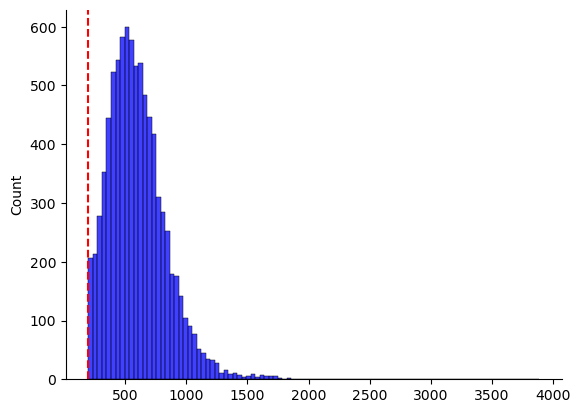

In [20]:
print(np.sum(trips_df['End'] - trips_df['Start']))
print(np.mean(trips_df['End'] - trips_df['Start']))

sns.histplot(trips_df['End'] - trips_df['Start'], bins=100, color="blue")
plt.axvline(x=min_interval_size, color='red', linestyle='--')
sns.despine()

In [21]:
trips_df['End'] - trips_df['Start']

0       501
1       910
2       971
3       557
4       633
       ... 
8647    383
8648    409
8649    882
8650    666
8651    390
Length: 8652, dtype: int64

In [22]:
# convert dataframes into pyranges for overlapping
# trips_pr = pr.PyRanges(trips_df.head(10))
trips_pr = pr.PyRanges(trips_df)
pile1 = pr.PyRanges(pileup_dfs[0])
pile2 = pr.PyRanges(pileup_dfs[1])
pile3 = pr.PyRanges(pileup_dfs[2])



In [23]:

pile1_trips = pile1.join(trips_pr, report_overlap=True, how='right')
pile2_trips = pile2.join(trips_pr, report_overlap=True, how='right')
pile3_trips = pile3.join(trips_pr, report_overlap=True, how='right')

pile1_trips = pile1_trips.df
pile2_trips = pile2_trips.df
pile3_trips = pile3_trips.df


In [24]:
print(pile1_trips.shape)
print(pile2_trips.shape)
print(pile3_trips.shape)

(317463, 15)
(308687, 15)
(336332, 15)


In [25]:
# midpoints = np.column_stack((pile1_trips.fold_diff, 
#                         pile2_trips.fold_diff, 
#                         pile3_trips.fold_diff))
# print(np.corrcoef(midpoints, rowvar=False))


In [49]:

# pile1_trips_summary = pile1_trips.groupby('trip_id').agg({'fold_diff': ['max', 'mean', 'median']})
# pile2_trips_summary = pile2_trips.groupby('trip_id').agg({'fold_diff': ['max', 'mean', 'median']})
# pile3_trips_summary = pile3_trips.groupby('trip_id').agg({'fold_diff': ['max', 'mean', 'median']})

# maxs may have fewer entries than this may be less than the trips_df if there are multiple rows with the same trip_id
# maxs = np.column_stack((pile1_trips_summary.fold_diff['max'],
#                     pile2_trips_summary.fold_diff['max'],
#                     pile3_trips_summary.fold_diff['max']))
# means = np.column_stack((pile1_trips_summary.fold_diff['mean'],
#                     pile2_trips_summary.fold_diff['mean'],
#                     pile3_trips_summary.fold_diff['mean']))
# medians = np.column_stack((pile1_trips_summary.fold_diff['median'],
#                     pile2_trips_summary.fold_diff['median'],
#                     pile3_trips_summary.fold_diff['median']))

# for each trip_id in each replicate, get average fold diff wtihin each interval, weighted by number of bases in pileup
f = lambda x: np.average(x.fold_diff, weights=x.bases)


pile1_trips_summary = pile1_trips.groupby('trip_id').apply(f)
pile2_trips_summary = pile2_trips.groupby('trip_id').apply(f)
pile3_trips_summary = pile3_trips.groupby('trip_id').apply(f)
wavg = np.column_stack((pile1_trips_summary,
                    pile2_trips_summary,
                    pile3_trips_summary))
print(wavg.shape)
print(np.corrcoef(wavg, rowvar=False))



# print(maxs.shape)
# print(means.shape)
# print(np.corrcoef(maxs, rowvar=False))
# print(np.corrcoef(means, rowvar=False))

# # look at correlation just for peaks with fold diffs greater than 3
# indices = np.where(np.sum(maxs > 3, axis=1) == 3)
# maxs_3fold = np.min(maxs[indices])
# print(np.min(maxs))
# print(np.min(maxs[indices]))
# print(np.corrcoef(maxs[indices], rowvar=False))

# maxs_3fold = np.min(maxs[indices])
#np.min(maxs)

(8652, 3)
[[1.         0.93537065 0.94297342]
 [0.93537065 1.         0.94075784]
 [0.94297342 0.94075784 1.        ]]


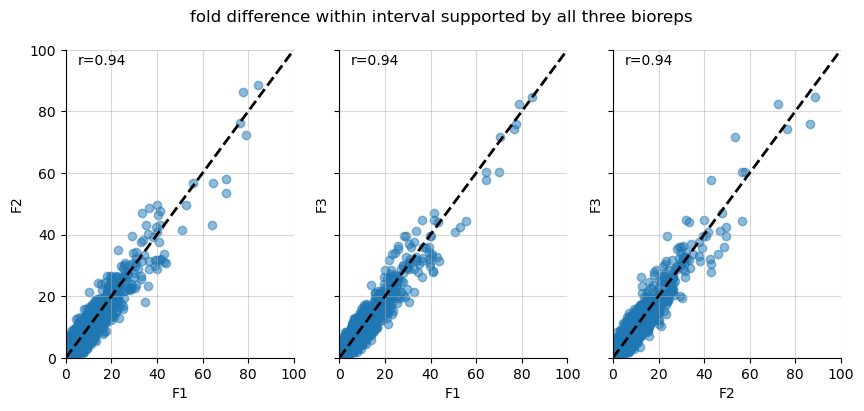

In [53]:
combos = list(itertools.combinations(range(wavg.shape[1]), 2))
combos

fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,combo in enumerate(combos):
    axs[i].scatter(wavg[:,combo[0]], wavg[:,combo[1]], alpha=0.5)
    axs[i].set_xlabel(f"F{combo[0]+1}")
    axs[i].set_ylabel(f"F{combo[1]+1}")
    axs[i].set_xlim(0,100)
    axs[i].set_ylim(0,100)
    axs[i].plot([0, 100], [0, 100], linewidth=2, color='black', linestyle='--')
    # add grid lines
    axs[i].grid(True, alpha=0.5)
    # add correlation coefficient in plot
    corr = np.corrcoef(wavg[:,combo[0]], wavg[:,combo[1]])[0,1]
    axs[i].text(0.05, 0.95, f"r={corr:.2f}", transform=axs[i].transAxes)
fig.suptitle("fold difference within interval supported by all three bioreps")
sns.despine()

medians: [2.98557855 2.96911693 3.04431736]
means: [4.26939236 4.23903044 4.27255433]
variances: [22.73197429 22.02103613 22.2404148 ]
means of logged: [0.52924352 0.52975121 0.53777746]
variances of logged: [0.0652603  0.06279086 0.05918067]


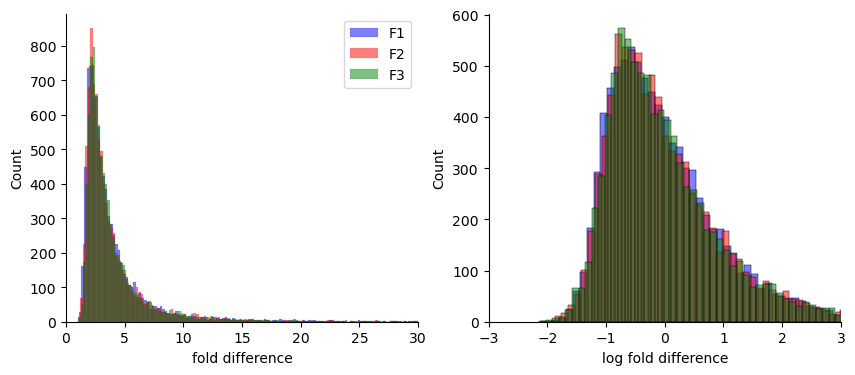

In [54]:
# are there systematic differences in fold differences across replicates?
print("medians:", np.median(wavg, axis=0))
print("means:", np.mean(wavg, axis=0))
print("variances:", np.var(wavg, axis=0))
print("means of logged:", np.mean(np.log10(wavg), axis=0))
print("variances of logged:", np.var(np.log10(wavg), axis=0))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(wavg[:,0], color="blue", alpha=0.5, label="F1", ax=axs[0])
sns.histplot(wavg[:,1], color="red", alpha=0.5, label="F2", ax=axs[0])
sns.histplot(wavg[:,2], color="green", alpha=0.5, label="F3", ax=axs[0])
axs[0].set_xlim(0,30)
axs[0].set_xlabel("fold difference")
axs[0].legend()

wavg_norm = (np.log10(wavg) - np.mean(np.log10(wavg), axis=0)) / np.std(np.log10(wavg), axis=0)
# wavg_norm = (np.log10(wavg) - np.mean(np.log10(wavg), axis=0)) / (np.max(np.log10(wavg), axis=0) - np.min(np.log10(wavg), axis=0))

# wavg_norm = (wavg - np.mean(wavg, axis=0)) / np.std(wavg, axis=0)

sns.histplot((wavg_norm[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[1])
sns.histplot((wavg_norm[:,1]), color="red", alpha=0.5, label="F2", ax=axs[1])
sns.histplot((wavg_norm[:,2]), color="green", alpha=0.5, label="F3", ax=axs[1])
# sns.histplot(np.log10(wavg[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[1])
# sns.histplot(np.log10(wavg[:,1]), color="red", alpha=0.5, label="F2", ax=axs[1])
# sns.histplot(np.log10(wavg[:,2]), color="green", alpha=0.5, label="F3", ax=axs[1])
axs[1].set_xlim(-3,3)
axs[1].set_xlabel("log fold difference")

sns.despine()


In [ ]:
# make a qqplot of the logged maxs data and compare to log normal distribution




: 

In [ ]:
# plot the maxs data except normalize all the values by the column mean and variances
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(np.log10(maxs[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[0])
sns.histplot(np.log10(maxs[:,1]), color="red", alpha=0.5, label="F2", ax=axs[0])
sns.histplot(np.log10(maxs[:,2]), color="green", alpha=0.5, label="F3", ax=axs[0])
axs[0].set_xlim(0,2)

# maxs_norm = (maxs - np.mean(maxs, axis=0)) / np.std(maxs, axis=0)
maxs_norm = (np.log10(maxs) - np.mean(np.log10(maxs), axis=0)) / np.std(np.log10(maxs), axis=0)
sns.histplot(maxs_norm[:,0], color="blue", alpha=0.5, label="F1", ax=axs[1])
sns.histplot(maxs_norm[:,1], color="red", alpha=0.5, label="F2", ax=axs[1])
sns.histplot(maxs_norm[:,2], color="green", alpha=0.5, label="F3", ax=axs[1])
axs[1].set_xlim(-5,5)
sns.despine()


: 

# look at specific triplet interval

    Chromosome  Start    End  p1  p2  p3 combined
8   NMEL_chr_1   9297   9309   0   0   1      001
9   NMEL_chr_1   9309   9649   0   1   1      011
10  NMEL_chr_1   9649  10150   1   1   1      111
11  NMEL_chr_1  10150  10843   1   1   0      110
12  NMEL_chr_1  10843  10914   1   0   0      100
501


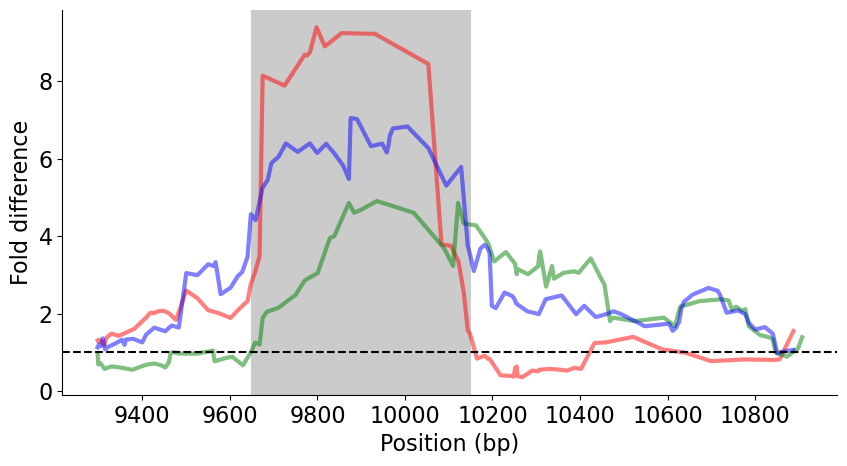

In [30]:
# for Nmel, index 4 messy, 2 nice, 38 pcr duplicate?
candidate_trip_indices = trips_indices[0]
candidate_trip_df = overlaps_per_rep.iloc[candidate_trip_indices]
candidate_trip_pr = pr.PyRanges(candidate_trip_df)
print(candidate_trip_df)
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
colors = ['red', 'green', 'blue']
for i,p in enumerate([pile1, pile2, pile3]):
    candidate_trip_pile = candidate_trip_pr.join(p, report_overlap=True, how='left')
    sns.lineplot(x=candidate_trip_pile.midpoint, y=candidate_trip_pile.fold_diff, linewidth=3, alpha=0.5, color=colors[i])

# add shaded background using start and stop coordinates where 'combined' pattern == 111
tmp = candidate_trip_df[candidate_trip_df['combined'] == '111']
for i,r in tmp.iterrows():
    print((r['End'] - r['Start']))
    if (r['End'] - r['Start']) > min_interval_size:
        axs.axvspan(r['Start'], r['End'], facecolor='0.2', alpha=0.25)

# increase font sizes
axs.set_xlabel("Position (bp)", fontsize=16)
axs.set_ylabel("Fold difference", fontsize=16)
# increase x and y axes font size
axs.tick_params(axis='both', which='major', labelsize=16)
plt.axhline(y=1, color='black', linestyle='--')
sns.despine()


In [ ]:
candidate_trip_df[candidate_trip_df['combined'] == '111']
#  df = df[df['combined'].isin(support_patterns)]

: 

In [ ]:
num_points = 833/100
833/num_points

: 

In [ ]:
stop

: 

# APPENDIX

# COMPARE SUMMITS (NOT PEAKS, WHICH IS THE ENTIRE INTERVAL CALLED BY METHOD)

In [ ]:

# look at overlaps between methods within bioreps
macs_summit_overlaps, genrich_summit_overlaps = fn.get_summit_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, dist_thresh)
print(macs_summit_overlaps)
print(genrich_summit_overlaps)
for i,m in enumerate(macs_summit_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_summit_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# look at overlaps within methods between bioreps
macs_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(macs_dfs, bioreps, dist_thresh)
genrich_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(genrich_dfs, bioreps, dist_thresh)

print(macs_summit_overlaps)
print(genrich_summit_overlaps)

: 

In [ ]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[0][i].bar(range(len(comp)), comp, color="blue")
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[1][i].bar(range(len(comp)), comp, color="blue")
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

: 

: 

: 

In [ ]:
maxs = []
means = []

# pile1 = pr.PyRanges(pileup_dfs[0])
# pile2 = pr.PyRanges(pileup_dfs[1])
# pile3 = pr.PyRanges(pileup_dfs[2])

for t in triplet_peaks[0:10]:
    df = overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    # CURRENTLY IGNORING INTERVALS WITH MULTIPLE INTERVALS OF SUPPORT FROM 3 REPLICATES
    if len(df) > 1:
        continue
    chrom = df['Chromosome'].unique()[0]

    p = pr.PyRanges(df)
    pile1 = pr.PyRanges(pileup_dfs[0][pileup_dfs[0]['Chromosome'] == chrom])
    pile2 = pr.PyRanges(pileup_dfs[1][pileup_dfs[1]['Chromosome'] == chrom])
    pile3 = pr.PyRanges(pileup_dfs[2][pileup_dfs[2]['Chromosome'] == chrom])    

    # pile1 = pr.PyRanges(pileup_dfs[0][(pileup_dfs[0]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[0]['Start'] >= np.min(df['Start'])) &
    #                                     (pileup_dfs[0]['End'] <= np.max(df['End']))])
    # pile2 = pr.PyRanges(pileup_dfs[1][(pileup_dfs[1]['Chromosome'] == chrom) & 
    #                                   (pileup_dfs[1]['Start'] >= np.min(df['Start'])) &
    #                                 (pileup_dfs[1]['End'] <= np.max(df['End']))])
    # pile3 = pr.PyRanges(pileup_dfs[2][(pileup_dfs[2]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[2]['Start'] >= np.min(df['Start'])) &
    #                                   (pileup_dfs[2]['End'] <= np.max(df['End']))])    

    # print(df['End']-df['Start'])
    # df.head()
    fold_diffs = [np.array(pile1.overlap(p).fold_diff), 
                  np.array(pile2.overlap(p).fold_diff), 
                  np.array(pile3.overlap(p).fold_diff)]


    maxs.append([np.max(x) for x in fold_diffs])
    means.append([np.mean(x) for x in fold_diffs])



: 

In [ ]:
df


: 

In [ ]:
len(triplet_peaks)

: 

In [ ]:
# p1 = pr.PyRanges(genrich_dfs[0])
# p1 = pr.PyRanges(genrich_dfs[1])
# p1 = pr.PyRanges(genrich_dfs[2])
# gr = {"p1":p1, "p2":p2, "p3":p3}
# overlaps_per_rep = pr.count_overlaps(gr)


: 

In [ ]:
overlaps_per_rep

: 

In [ ]:
genrich_dfs[0]

: 

In [ ]:
print(p1.coverage(p2, overlap_col="C", fraction_col="F").head())
print(p1.coverage(p3, overlap_col="C", fraction_col="F").head())
print(p2.coverage(p3, overlap_col="C", fraction_col="F").head())



: 